In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu


# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 100
oversample = 4

nwavels = 10
npoly = 2
n_zernikes = 12#-1

optics = NICMOSColdMaskFresnelOptics(512, wid, oversample, 0., 0., n_zernikes = n_zernikes)
#optics = NICMOSFresnelOptics(512, wid, oversample, 0., n_zernikes = n_zernikes)
#optics = NICMOSOptics(512, wid, oversample,n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)


#ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
#fname = ddir + 'HST/n43ca5feq_cal.fits'


ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    #'n4be02nqq_cal.fits',
    #'n4be02ntq_cal.fits',
    ##'n4be02nwq_cal.fits',
    #'n4be02o0q_cal.fits',
][:1]#[-2:-1]"""

#ddir = "../data/MAST_2025-06-20T23_47_51.088Z/HST/"

#files = [
#    "na2ma5mrq_cal.fits",
#    "na2ma5msq_cal.fits",
#    "na2ma5mtq_cal.fits",
#    "na2ma5muq_cal.fits",
#    "na2ma5mvq_cal.fits",
#    "na2ma5mwq_cal.fits",
#][:1]

exposures = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=None) for file in files]


Filename: ../data/MAST_2025-03-06T11_35_52.340Z/HST/n4be02npq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     300   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.0
2.3022


In [4]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

49 50


In [5]:
exposures[0].filter

'F110M'

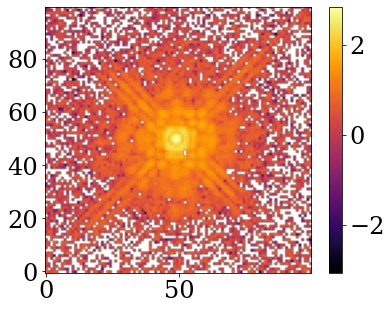

In [6]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

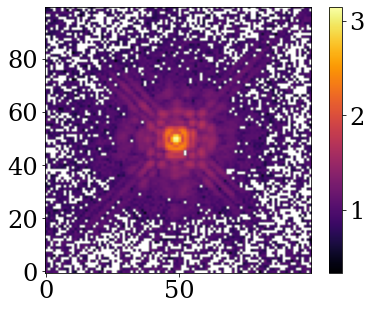

In [7]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [8]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2,
    "bias": {},
    "jitter": {},
    #"defocus": {},
    "displacement": 0.1
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] =     params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
          -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
           7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8., 8.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["defocus"][exp.fit.get_key(exp, "defocus")] = 0.

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

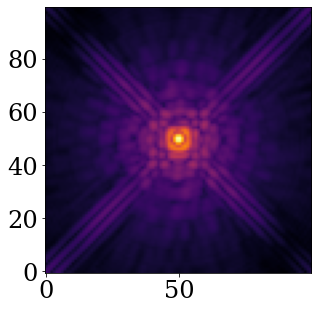

In [9]:
plt.imshow(exposures[0].fit(params.inject(model),exposures[0])**0.125)

In [10]:
params

ModelParams(
  params={
    'positions':
    {'n4be02npq': f64[2]},
    'spectrum':
    {'HD201592_F110M': f64[2]},
    'aberrations':
    {'n4be02npq': f64[12]},
    'cold_mask_shift':
    {'global': f64[2]},
    'cold_mask_rot':
    {'global': -45.0},
    'cold_mask_scale':
    {'F110M': f64[2]},
    'cold_mask_shear':
    {'F110M': f64[2]},
    'primary_scale':
    {'F110M': f64[2]},
    'primary_rot':
    {'F110M': 45.0},
    'primary_shear':
    {'F110M': f64[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0432,
    'softening':
    2,
    'bias':
    {'n4be02npq': 0.0},
    'jitter':
    {'n4be02npq': 0.6511627906976745},
    'displacement':
    0.1
  }
)

In [11]:
print(params.params)

{'positions': {'n4be02npq': Array([0., 0.], dtype=float64)}, 'spectrum': {'HD201592_F110M': Array([4.01322875, 0.        ], dtype=float64)}, 'aberrations': {'n4be02npq': Array([  0.        ,  24.884588  , -25.489779  , -17.15699   ,
       -21.790146  ,  -4.592212  ,  -4.832893  ,  19.196083  ,
         0.37983412,   7.0756216 ,   0.30277824,  -6.330534  ],      dtype=float64)}, 'cold_mask_shift': {'global': Array([8., 8.], dtype=float64)}, 'cold_mask_rot': {'global': -45.0}, 'cold_mask_scale': {'F110M': Array([1., 1.], dtype=float64)}, 'cold_mask_shear': {'F110M': Array([0., 0.], dtype=float64)}, 'primary_scale': {'F110M': Array([1., 1.], dtype=float64)}, 'primary_rot': {'F110M': 45.0}, 'primary_shear': {'F110M': Array([0., 0.], dtype=float64)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0432, 'softening': 2, 'bias': {'n4be02npq': 0.0}, 'jitter': {'n4be02npq': 0.6511627906976745}, 'displacement': 0.1}


In [12]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*8, 10),#, (20, 1.5)),
    #"cold_mask_shift": opt(g*100, 30),
    "cold_mask_shift": opt(g*100, 30),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*3, 20),
    #"aberrations": opt(g*0.15,300),#, (80, 2)),#, (150, g*0.2)),
    #"aberrations": opta(2, 50),
    #"defocus": opt(g*100, 50),
    "aberrations": opta(2, 100),
    "displacement": opt(g*30, 200),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [13]:
losses, models = optimise(params, model, exposures, things, 500)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'n4be02npq': {'positions': Array([[19683104.71371973,  -562771.25315694],
       [ -562771.25315694,  6507968.7986431 ]], dtype=float64), 'spectrum': Array([[95547922.43133408,  1214760.44601721],
       [ 1214760.44601719, 14233276.40941299]], dtype=float64), 'cold_mask_shift': Array([[-236552.13524204,   21063.27750924],
       [  21063.27750924, -242906.20321949]], dtype=float64), 'bias': Array([[183378.80936533]], dtype=float64), 'aberrations': Array([[ -71.11530856,  -33.11907748, -114.65131123,  -11.26368999,
          59.613022  ,  -73.96423584,  -11.00024576,   79.60081726,
         -30.51885124,  -20.01586488,   -3.38823638,  -46.54488061],
       [ -33.11907748, -138.39849577,  -39.37415613,   51.30882717,
           7.69292018,   63.86724138,    5.37408778,  -27.46427637,
         -24.64657485,  106.28070611,  -19.44198958,  -57.57445665],
       [-114.65131123,  -39.37415613,  -64.4769624 ,   52.81333201,
          64.419898  ,   41.28909808,  119.45076829,  -89.88673792,


  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
losses[-1]
#72266.48208278

Array(57265.95458033, dtype=float64)

In [15]:
losses

[Array(3359613.22314922, dtype=float64),
 Array(1879184.32656366, dtype=float64),
 Array(1052929.72268685, dtype=float64),
 Array(619515.14913099, dtype=float64),
 Array(388183.20341841, dtype=float64),
 Array(261712.87199011, dtype=float64),
 Array(191472.85646384, dtype=float64),
 Array(152139.75209317, dtype=float64),
 Array(130035.31434465, dtype=float64),
 Array(117601.50891006, dtype=float64),
 Array(110611.44800862, dtype=float64),
 Array(106703.06154666, dtype=float64),
 Array(104537.7608739, dtype=float64),
 Array(103294.79646914, dtype=float64),
 Array(102561.13388561, dtype=float64),
 Array(102120.53903003, dtype=float64),
 Array(101853.50751351, dtype=float64),
 Array(101690.45505309, dtype=float64),
 Array(101589.44423612, dtype=float64),
 Array(101524.9226665, dtype=float64),
 Array(101481.46278896, dtype=float64),
 Array(97930.30921273, dtype=float64),
 Array(96293.91925006, dtype=float64),
 Array(95688.37554664, dtype=float64),
 Array(95516.52043912, dtype=float64),
 Ar

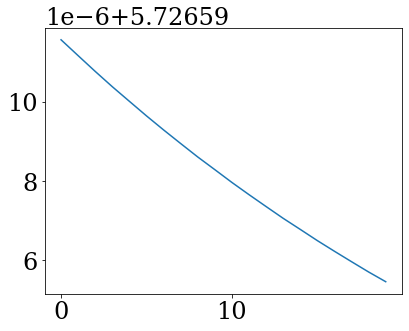

In [16]:
plt.plot(np.asarray(losses[-20:])/(len(exposures)*wid**2))

6


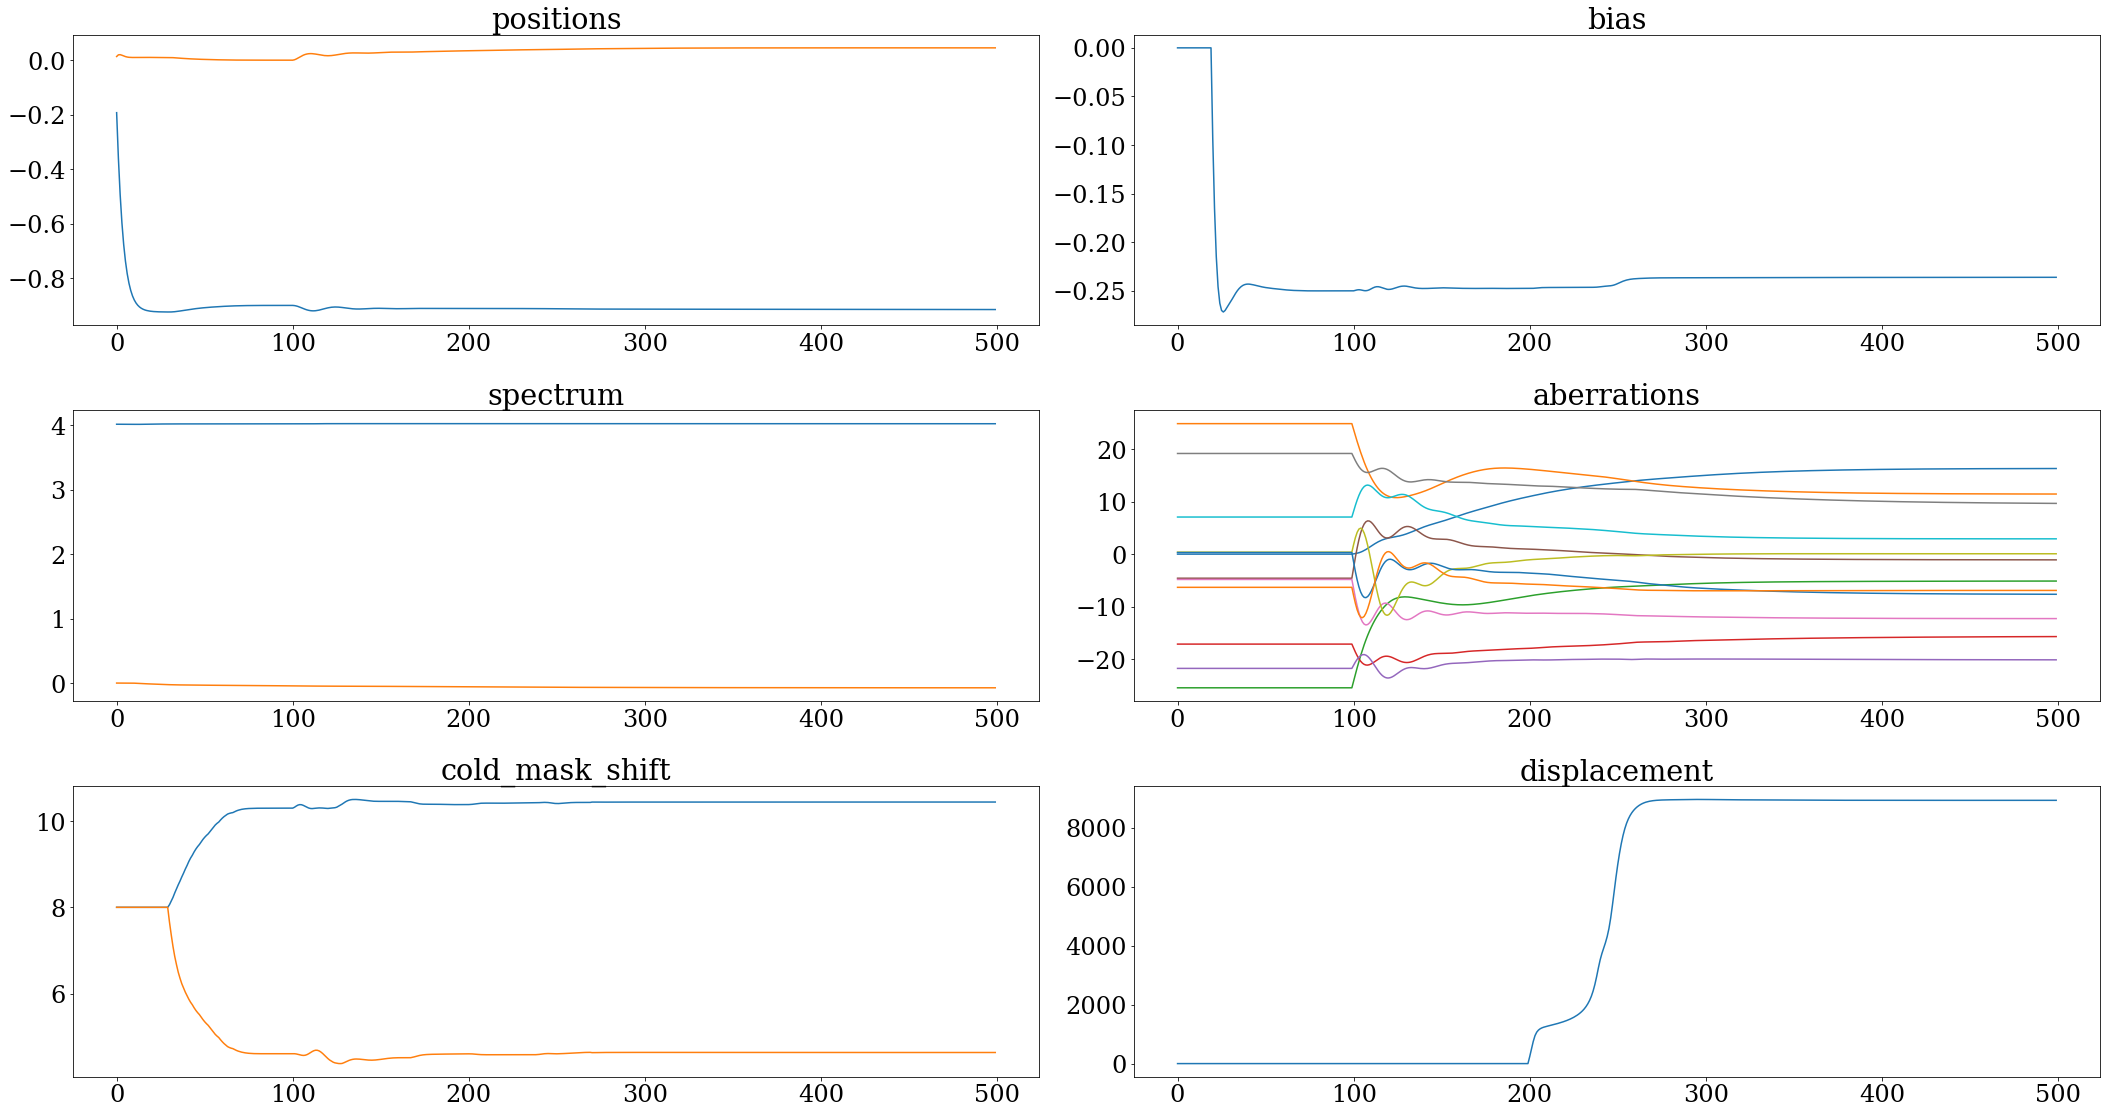

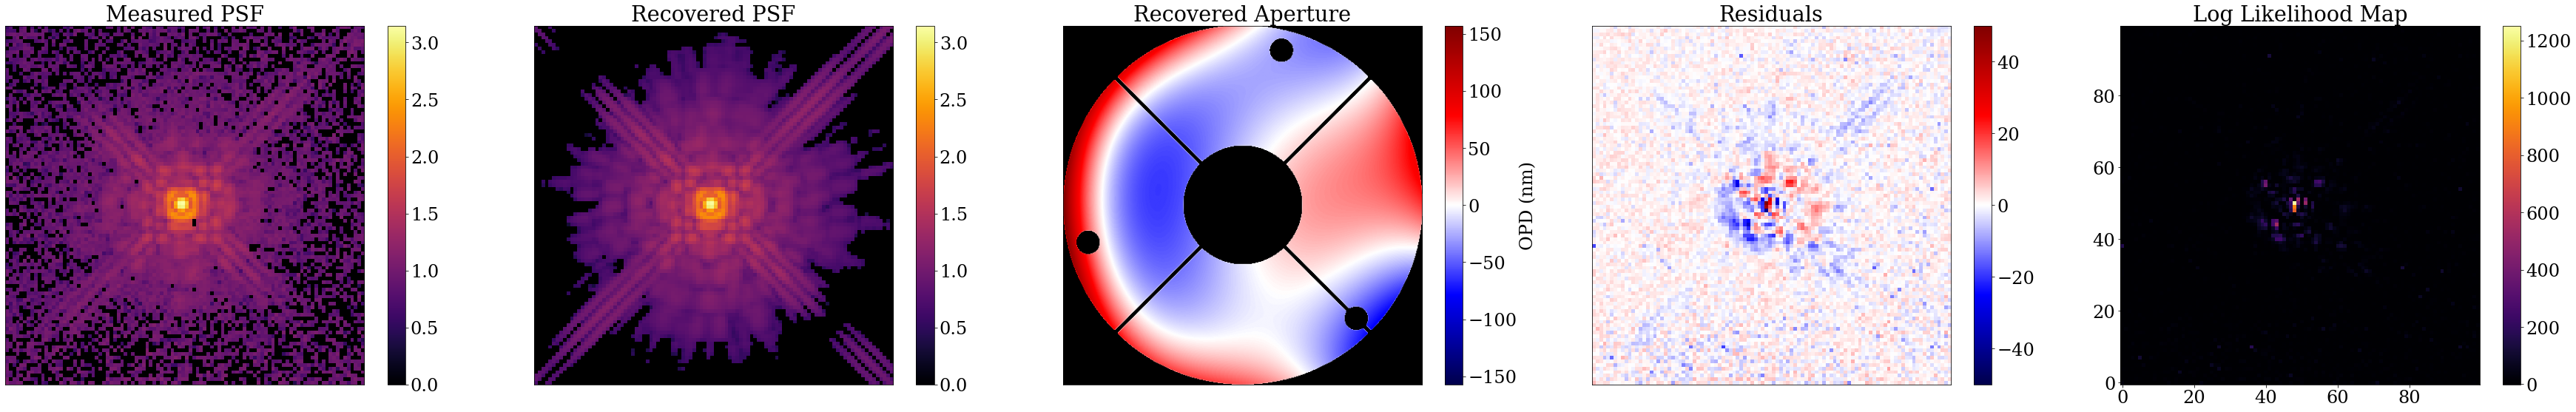

In [17]:
plot_params(models, groups, xw = 3)
plot_comparison(model, models[-1], exposures)